## Project Parameters

In [2]:
project_name = "k9mail-5.304"
project_root = "Datasets/k9mail/"
src_path = "k9mail-5.304/k9mail/src/main/java/"
graph_path = "k9mail-5.304.json"

(project_name,project_root,src_path,graph_path)

('k9mail-5.304',
 'Datasets/k9mail/',
 'k9mail-5.304/k9mail/src/main/java/',
 'k9mail-5.304.json')

## Imports

In [3]:
import random
import json

## Relationship Operations

In [38]:
def compose(tuples1, tuples2, retain1=False, retain2=False):
    result = set()

    # Create a dictionary to store intermediate values
    intermediate_dict = {}

    # Populate the intermediate dictionary with values from tuples2
    for source2, target2 in tuples2:
        intermediate_dict.setdefault(source2, []).append(target2)

    # Iterate through tuples1 and find transitive pairs
    for source1, target1 in tuples1:
        if target1 in intermediate_dict:
            for target2 in intermediate_dict[target1]:
                result.add((source1, target2))

    # tuples in tuples1 with which 2nd element is not in tuple2's 1st elements
    if retain1:
        result |= {(s1, t1) for s1, t1 in tuples1 if all(t1 != s2 for s2, _ in tuples2)}

    # tuples in tuples2 with which 1st element is not in tuple1's 2nd elements
    if retain2:
        result |= {(s2, t2) for s2, t2 in tuples2 if all(s2 != t1 for _, t1 in tuples1)}

    return result

# Example usage:
t1 = [(1, 2), (2, 3), (2, 4), (3, 4), (3, 98)]
t2 = [(2, 'a'), (3, 'b'), (4, 'c'), (4, 'd'), (3, 'c'), (99, 'c')]

print(compose(t1, t2))
print(compose(t1, t2, retain1=True))
print(compose(t1, t2, retain2=True))
print(compose(t1, t2, retain1=True, retain2=True))


{(2, 'b'), (1, 'a'), (2, 'd'), (3, 'd'), (3, 'c'), (2, 'c')}
{(2, 'b'), (1, 'a'), (3, 98), (2, 'd'), (3, 'd'), (3, 'c'), (2, 'c')}
{(2, 'b'), (1, 'a'), (2, 'd'), (3, 'd'), (99, 'c'), (3, 'c'), (2, 'c')}
{(2, 'b'), (1, 'a'), (3, 98), (2, 'd'), (3, 'd'), (99, 'c'), (3, 'c'), (2, 'c')}


In [6]:
def flip_tuples(tuples):
    return {(b, a) for a, b in tuples}

# Example usage:
t = [(1, 2), (3, 4), ('a', 'b')]
flipped = flip_tuples(t)

print(flipped)


{('b', 'a'), (2, 1), (4, 3)}


## Load javapers output

This is the "detailed" graph, i.e., it contains packages, classes, methods, variables. This is a labeled property graph, so a node has id, label, and properties, while an edge has source, target, type, and properties. In both, a property is an arbitrary key-value pair.

In [54]:
with open(project_root+graph_path, encoding="utf8") as json_file:
    data = json.load(json_file)

# samples: first node and first edge in the dataset, just for illustration of how they look like
data['elements']['nodes'][0], data['elements']['edges'][0]

({'data': {'id': 'com.fsck.k9.activity.compose.RecipientLoader.PROJECTION_CRYPTO_ADDRESSES',
   'properties': {'sourceText': 'private static final java.lang.String[] PROJECTION_CRYPTO_ADDRESSES = new java.lang.String[]{ "address", "uid_address" };',
    'visibility': 'private',
    'simpleName': 'PROJECTION_CRYPTO_ADDRESSES',
    'kind': 'field',
    'metaSrc': 'source code'},
   'labels': ['Variable']}},
 {'data': {'id': 'ac7cba3e978bef0c69a74a9b1b4a1e08',
   'source': 'com.fsck.k9.notification.NotificationController.getAccountName(com.fsck.k9.Account).account',
   'label': 'type',
   'properties': {'weight': 1, 'metaSrc': 'source code'},
   'target': 'com.fsck.k9.Account'}})

Put the data in dictionaries with simpler structure for the sake of further processing.

The nodes are now represented as a dictionary where the key is a tuple of (node_id, node_label) and the value is the node properties.

Similarly, the edges are now represented as a dictionary where the key is a tuple of (source, target, edge_type) and the value is the edge properties.

In [55]:
def cy_to_rels(cy_data):
	nodes = {(node['data']['id'],node['data']['labels'][0]):node['data']['properties'] for node in cy_data['elements']['nodes']}
	edges = {(edge['data']['source'],edge['data']['target'],edge['data']['label']):edge['data']['properties'] for edge in cy_data['elements']['edges']}
	return nodes,edges

nodes,edges = cy_to_rels(data)
(len(nodes), len(edges)), random.sample(nodes.items(), 5), random.sample(edges.items(), 5)

((13432, 28061),
 [(('com.fsck.k9.notification.RemoveNotificationResult.com.fsck.k9.notification.RemoveNotificationResult(com.fsck.k9.notification.NotificationHolder,int,boolean).notificationId',
    'Variable'),
   {'simpleName': 'notificationId',
    'kind': 'parameter',
    'metaSrc': 'source code'}),
  (('com.fsck.k9.mailstore.CryptoResultAnnotation$CryptoError', 'Structure'),
   {'docComment': '',
    'simpleName': 'CryptoError',
    'kind': 'enum',
    'metaSrc': 'source code'}),
  (('com.fsck.k9.Account.getTrashFolderName()', 'Operation'),
   {'sourceText': 'public synchronized java.lang.String getTrashFolderName() {\r\n    return trashFolderName;\r\n}',
    'docComment': '',
    'visibility': 'public',
    'simpleName': 'getTrashFolderName()',
    'kind': 'method',
    'metaSrc': 'source code'}),
  (('com.fsck.k9.activity.Accounts.onCreateContextMenu(android.view.ContextMenu,android.view.View,android.view.ContextMenu.ContextMenuInfo).menuInfo',
    'Variable'),
   {'simpleName'

Now I'm going to convert the data (yet again) into "relationships". A relationship R is a set of tuples (A,B) in which A and B are nodes in the graph, and there is an edge of type R from A to B.

First let's see what relationships are there:

In [9]:
rel_types = {typ for (_, _, typ) in edges}
rel_types

{'contains',
 'hasParameter',
 'hasScript',
 'hasVariable',
 'instantiates',
 'invokes',
 'returnType',
 'specializes',
 'type'}

This is the real conversion:

In [10]:
detailed_rels = {rel_type:{(source,target) for (source, target, typ) in edges if typ == rel_type} for rel_type in rel_types}

[(rel_type, len(detailed_rels[rel_type])) for rel_type in detailed_rels]

[('type', 5238),
 ('hasParameter', 5132),
 ('hasVariable', 2984),
 ('contains', 925),
 ('specializes', 159),
 ('returnType', 1983),
 ('hasScript', 4653),
 ('invokes', 6266),
 ('instantiates', 721)]

Some samples of the relationships we get from the dataset:

In [11]:
{rel_type:random.sample(rel,2) for rel_type, rel in detailed_rels.items()}

{'type': [('com.fsck.k9.helper.MergeCursorWithUniqueId.mIdColumnIndex', 'int'),
  ('com.fsck.k9.service.PushService.startService(android.content.Intent,int).startId',
   'int')],
 'hasParameter': [('com.fsck.k9.provider.EmailProvider$SpecialColumnsCursor.com.fsck.k9.provider.EmailProvider$SpecialColumnsCursor(android.database.Cursor,java.lang.String[],java.util.Map)',
   'com.fsck.k9.provider.EmailProvider$SpecialColumnsCursor.com.fsck.k9.provider.EmailProvider$SpecialColumnsCursor(android.database.Cursor,java.lang.String[],java.util.Map).allColumnNames'),
  ('com.fsck.k9.mailstore.LocalFolder.deleteMessageRow(android.database.sqlite.SQLiteDatabase,long)',
   'com.fsck.k9.mailstore.LocalFolder.deleteMessageRow(android.database.sqlite.SQLiteDatabase,long).messageId')],
 'hasVariable': [('com.fsck.k9.K9', 'com.fsck.k9.K9.mCountSearchMessages'),
  ('com.fsck.k9.activity.setup.AccountSettings',
   'com.fsck.k9.activity.setup.AccountSettings.spamFolder')],
 'contains': [('com.fsck.k9.messag

I'm going to generate the abstract graph from the detailed graph above.

For the nodes, I'm going to only take the packages (Containers) and classes (Structures).

In [39]:
containers = {id for (id,label) in nodes if label == 'Container'}
structures = {id for (id,label) in nodes if label == 'Structure'}
random.sample(containers,10), random.sample(structures,5)

(['com.fsck.k9.helper.jsoup',
  'com.fsck.k9.preferences',
  'com.fsck',
  'com.fsck.k9.widget.list',
  'com.fsck.k9.setup',
  'com.fsck.k9.ui.compose',
  'com.fsck.k9.activity.misc',
  'com.fsck.k9.mailstore',
  'com.fsck.k9.message.quote',
  'com.fsck.k9.notification'],
 ['com.fsck.k9.mailstore.LocalFolder$PreferencesHolder',
  'com.fsck.k9.notification.NotificationGroupKeys',
  'com.fsck.k9.provider.MessageProvider$PreviewExtractor',
  'com.fsck.k9.message.html.BitcoinUriParser',
  'com.fsck.k9.view.RecipientSelectView'])

For the edges, I'm using the transitive properties, e.g., the relationship C1 "calls" C2 means: the class C1 "hasScript" S1, S1 "invokes" the script S2, and the class C2 "hasScript" S2.

In [13]:
abstract_rels = dict()

abstract_rels['contains'] = detailed_rels['contains']
abstract_rels['specializes'] = detailed_rels['specializes']
abstract_rels['holds'] = compose(detailed_rels['hasVariable'], detailed_rels['type'])
abstract_rels['accepts'] = compose(compose(detailed_rels['hasScript'], detailed_rels['hasParameter']), detailed_rels['type'])
abstract_rels['returns'] = compose(detailed_rels['hasScript'], detailed_rels['returnType'])
abstract_rels['constructs'] = compose(detailed_rels['hasScript'], detailed_rels['instantiates'])
abstract_rels['calls'] = compose(compose(detailed_rels['hasScript'], detailed_rels['invokes']), flip_tuples(detailed_rels['hasScript']))

[(rel_type, len(abstract_rels[rel_type])) for rel_type in abstract_rels]

[('contains', 925),
 ('specializes', 159),
 ('holds', 848),
 ('accepts', 1107),
 ('returns', 1129),
 ('constructs', 502),
 ('calls', 1351)]

Some samples of the abstracted relationships:

In [14]:
{rel_type:random.sample(rel,2) for rel_type, rel in abstract_rels.items()}

{'contains': [('com.fsck.k9.view.MessageHeader',
   'com.fsck.k9.view.MessageHeader$HeaderEntry'),
  ('com.fsck.k9', 'com.fsck.k9.K9$BACKGROUND_OPS')],
 'specializes': [('com.fsck.k9.preferences.IdentitySettings$SignatureSetting',
   'com.fsck.k9.preferences.Settings$SettingsDescription'),
  ('com.fsck.k9.activity.UnreadWidgetConfiguration',
   'com.fsck.k9.activity.K9PreferenceActivity')],
 'holds': [('com.fsck.k9.Account', 'com.fsck.k9.Account$Searchable'),
  ('com.fsck.k9.activity.Accounts$AccountsImportedDialog',
   'com.fsck.k9.preferences.SettingsImporter$ImportResults')],
 'accepts': [('com.fsck.k9.notification.NotificationController',
   'java.lang.String'),
  ('com.fsck.k9.activity.compose.AttachmentPresenter$AttachmentMvpView',
   'com.fsck.k9.activity.compose.AttachmentPresenter$WaitingAction')],
 'returns': [('com.fsck.k9.mailstore.migrations.MigrationsHelper',
   'com.fsck.k9.preferences.Storage'),
  ('com.fsck.k9.notification.NotificationController',
   'com.fsck.k9.notif

Now moving on to an example of call lifting; for that we focus on relationships "contains" and "calls".

In [15]:
random.sample(abstract_rels['contains'], 10)

[('com.fsck.k9.mailstore', 'com.fsck.k9.mailstore.MessageViewInfoExtractor'),
 ('com.fsck.k9', 'com.fsck.k9.FontSizes'),
 ('com.fsck.k9.activity.Accounts',
  'com.fsck.k9.activity.Accounts$AccountsImportedDialog'),
 ('com.fsck.k9.ui.message',
  'com.fsck.k9.ui.message.LocalMessageExtractorLoader'),
 ('com.fsck.k9.controller', 'com.fsck.k9.controller.MessagingListener'),
 ('com.fsck.k9.activity.setup',
  'com.fsck.k9.activity.setup.AccountSetupOutgoing'),
 ('com.fsck.k9.mailstore.migrations',
  'com.fsck.k9.mailstore.migrations.MigrationTo31'),
 ('com.fsck.k9.view',
  'com.fsck.k9.view.K9WebViewClient$PreLollipopWebViewClient'),
 ('com.fsck.k9', 'com.fsck.k9.Account$Expunge'),
 ('com.fsck.k9.activity', 'com.fsck.k9.activity.FolderList$FolderListHandler')]

In [16]:
random.sample(abstract_rels['calls'], 10)

[('com.fsck.k9.preferences.SettingsImporter',
  'com.fsck.k9.preferences.GlobalSettings'),
 ('com.fsck.k9.provider.EmailProvider$SpecialColumnsCursor',
  'com.fsck.k9.provider.EmailProvider$SpecialColumnsCursor'),
 ('com.fsck.k9.activity.MessageList', 'com.fsck.k9.Preferences'),
 ('com.fsck.k9.notification.NotificationController', 'com.fsck.k9.Account'),
 ('com.fsck.k9.activity.Accounts$PasswordPromptDialog',
  'com.fsck.k9.activity.Accounts$PasswordPromptDialog'),
 ('com.fsck.k9.Account', 'com.fsck.k9.K9'),
 ('com.fsck.k9.activity.compose.AttachmentPresenter',
  'com.fsck.k9.activity.compose.AttachmentPresenter$AttachmentMvpView'),
 ('com.fsck.k9.activity.Accounts$SimpleDialog',
  'com.fsck.k9.activity.Accounts$SimpleDialog'),
 ('com.fsck.k9.activity.Accounts$SetPasswordsAsyncTask',
  'com.fsck.k9.controller.MessagingController'),
 ('com.fsck.k9.message.extractors.MessageFulltextCreator',
  'com.fsck.k9.message.extractors.MessageFulltextCreator')]

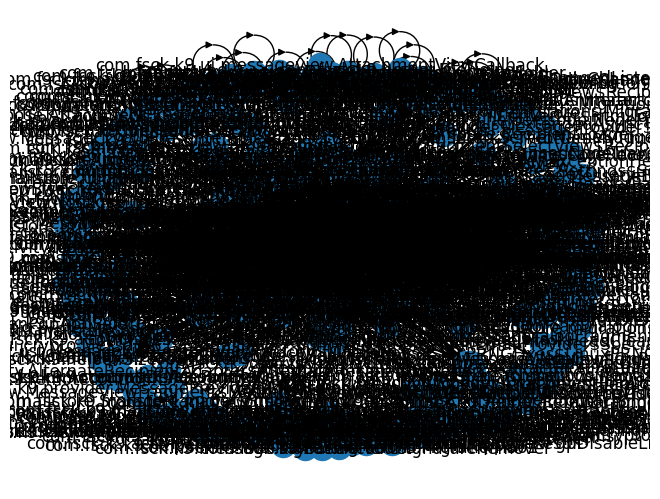

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()

g.add_edges_from(abstract_rels['calls'])

nx.draw_spring(g, with_labels=True)
plt.savefig("calls.png")


Here's the code to lift the calls.

In [22]:
# example: lift calls

lifted_calls = compose(
	compose(
		abstract_rels['contains'], 
		abstract_rels['calls']), 
	flip_tuples(abstract_rels['contains']))
len(lifted_calls), lifted_calls

(379,
 {('com.fsck.k9', 'com.fsck.k9'),
  ('com.fsck.k9', 'com.fsck.k9.Account'),
  ('com.fsck.k9', 'com.fsck.k9.K9'),
  ('com.fsck.k9', 'com.fsck.k9.PRNGFixes'),
  ('com.fsck.k9', 'com.fsck.k9.Throttle'),
  ('com.fsck.k9', 'com.fsck.k9.controller'),
  ('com.fsck.k9', 'com.fsck.k9.helper'),
  ('com.fsck.k9', 'com.fsck.k9.mailstore'),
  ('com.fsck.k9', 'com.fsck.k9.power'),
  ('com.fsck.k9', 'com.fsck.k9.preferences'),
  ('com.fsck.k9', 'com.fsck.k9.preferences.GlobalSettings'),
  ('com.fsck.k9', 'com.fsck.k9.provider'),
  ('com.fsck.k9', 'com.fsck.k9.search'),
  ('com.fsck.k9', 'com.fsck.k9.service'),
  ('com.fsck.k9', 'com.fsck.k9.widget.list'),
  ('com.fsck.k9.PRNGFixes', 'com.fsck.k9'),
  ('com.fsck.k9.PRNGFixes', 'com.fsck.k9.PRNGFixes'),
  ('com.fsck.k9.activity', 'com.fsck.k9'),
  ('com.fsck.k9.activity', 'com.fsck.k9.activity'),
  ('com.fsck.k9.activity', 'com.fsck.k9.activity.Accounts'),
  ('com.fsck.k9.activity', 'com.fsck.k9.activity.AlternateRecipientAdapter'),
  ('com.fsck.

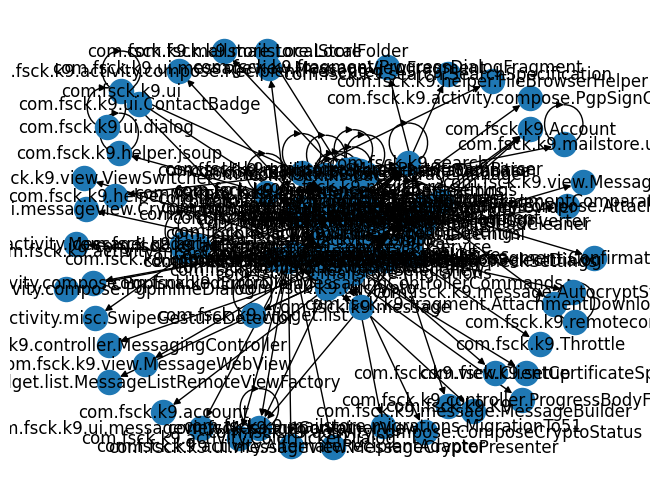

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()

g.add_edges_from(lifted_calls)

nx.draw_spring(g, with_labels=True)
plt.savefig("calls.png")


Selective lift---only lift specific containers.

In [40]:
def selective_lift(rels, rel, container_ids):
	selected_containments = {(source,target) for (source,target) in rels['contains'] if source in container_ids}
	inner = compose(
		selected_containments, 
		abstract_rels[rel], retain2=True)
	lifted_calls = compose(
		inner, 
		flip_tuples(selected_containments), retain1=True)
	return lifted_calls

lifted_selective = selective_lift(abstract_rels, 'calls', ['com.fsck.k9.view', 'com.fsck.k9.preferences'])
len(lifted_selective), lifted_selective

(1241,
 {('com.fsck.k9.activity.MessageCompose', 'com.fsck.k9.Preferences'),
  ('com.fsck.k9.activity.Accounts$SetPasswordsAsyncTask',
   'com.fsck.k9.Account'),
  ('com.fsck.k9.ui.messageview.AttachmentController$SaveAttachmentAsyncTask',
   'com.fsck.k9.ui.messageview.AttachmentController'),
  ('com.fsck.k9.mailstore.LocalMessage', 'com.fsck.k9.mailstore.LocalFolder'),
  ('com.fsck.k9.activity.MessageReference',
   'com.fsck.k9.helper.Preconditions'),
  ('com.fsck.k9.activity.setup.AccountSetupAccountType',
   'com.fsck.k9.Account'),
  ('com.fsck.k9.activity.AccountList$AccountsAdapter',
   'com.fsck.k9.BaseAccount'),
  ('com.fsck.k9.helper.ParcelableUtil', 'com.fsck.k9.helper.ParcelableUtil'),
  ('com.fsck.k9.activity.loader.AttachmentContentLoader',
   'com.fsck.k9.activity.misc.Attachment'),
  ('com.fsck.k9.mailstore.StorageManager$FixedStorageProviderBase',
   'com.fsck.k9.mailstore.StorageManager'),
  ('com.fsck.k9.activity.compose.RecipientPresenter',
   'com.fsck.k9.message.Pg

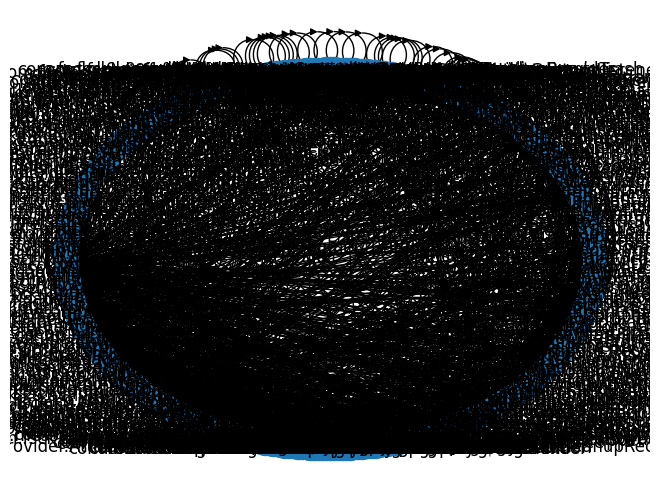

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()

g.add_edges_from(lifted_selective)

nx.draw_shell(g, with_labels=True)
plt.savefig("calls.png")


In [45]:

lifted_selective = selective_lift(abstract_rels, 'calls', containers)
len(lifted_selective), lifted_selective

(212,
 {('com.fsck.k9', 'com.fsck.k9'),
  ('com.fsck.k9', 'com.fsck.k9.controller'),
  ('com.fsck.k9', 'com.fsck.k9.helper'),
  ('com.fsck.k9', 'com.fsck.k9.mailstore'),
  ('com.fsck.k9', 'com.fsck.k9.power'),
  ('com.fsck.k9', 'com.fsck.k9.preferences'),
  ('com.fsck.k9', 'com.fsck.k9.provider'),
  ('com.fsck.k9', 'com.fsck.k9.search'),
  ('com.fsck.k9', 'com.fsck.k9.service'),
  ('com.fsck.k9', 'com.fsck.k9.widget.list'),
  ('com.fsck.k9.activity', 'com.fsck.k9'),
  ('com.fsck.k9.activity', 'com.fsck.k9.activity'),
  ('com.fsck.k9.activity', 'com.fsck.k9.activity.compose'),
  ('com.fsck.k9.activity', 'com.fsck.k9.activity.misc'),
  ('com.fsck.k9.activity', 'com.fsck.k9.activity.setup'),
  ('com.fsck.k9.activity', 'com.fsck.k9.autocrypt'),
  ('com.fsck.k9.activity', 'com.fsck.k9.controller'),
  ('com.fsck.k9.activity', 'com.fsck.k9.fragment'),
  ('com.fsck.k9.activity', 'com.fsck.k9.helper'),
  ('com.fsck.k9.activity', 'com.fsck.k9.mailstore'),
  ('com.fsck.k9.activity', 'com.fsck.k9.

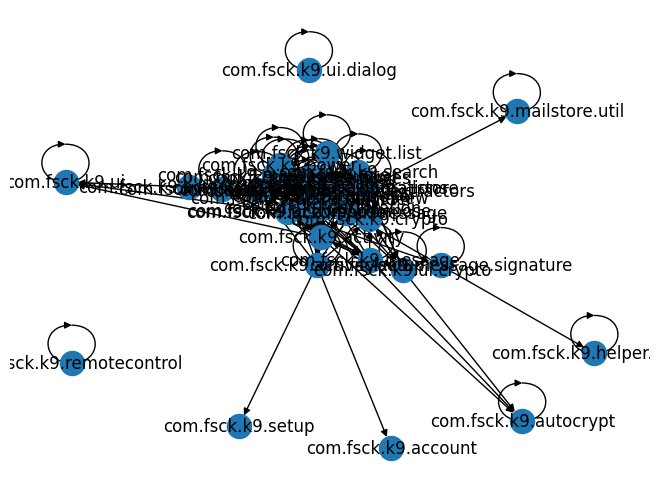

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()

g.add_edges_from(lifted_selective)

nx.draw_spring(g, with_labels=True)
plt.savefig("calls.png")


In [16]:
def find_nodes(nodes, id):
	return [(id_,label) for (id_,label) in nodes if id_ == id]

## networkx Stuff

In [ ]:
import networkx as nx

g = nx.MultiDiGraph()

for (id, label), properties in nodes.items():
    g.add_node(id, label=label, **properties)

for (source, target, typ), properties in edges.items():
    g.add_edge(source, target, type=typ, **properties)

g.number_of_nodes(), g.number_of_edges()

In [ ]:
for node, nbrsdict in list(g.adj.items())[:10]:
    print((node, nbrsdict))
    

In [ ]:
method_sources = {id:properties['sourceText'] for (id,label),properties in nodes.items() if label in ['Operation', 'Constructor']}
method_sources

## LLM Stuff

In [ ]:
from txtai.pipeline import LLM

# llm = LLM("Open-Orca/Mistral-7B-OpenOrca")
llm = LLM("microsoft/phi-2", trust_remote_code='True')
# llm = LLM("lmsys/vicuna-7b-v1.5")
for method_name, method_src in random.sample(method_sources.items(), 10):
	llm(
	f"""
	Answer the following question using the provided context.

	Question:
	What does this Java method do?

	Context:
	{method_src}
	"""
	)